<a href="https://colab.research.google.com/github/Juancarlos56/Repositorio-Simulacion-10/blob/main/Examenes/ExamenFinal_Simulacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Examen Simulación
### Realizado por: Juan Carlos Barrera Barrera

- Investigar los lugares de mayor afluencia dentro del Ecuador minimo 6.
- El número de la flota de buses son 5, con una capacidad de 40 pasajeros cada uno.
- Generar personas, un nombre, el género(Bernoulli), y la edad adultos (Poison)
aleatoriamente.
- Un usuario realiza la compra de un boleto desde un lugar de origen a un destino y
puede comprar de 1 a 6 tickets.
- Es escoge aleatoriamente el origen y el destino con mayores pesos de selección lo
de mayor afluencia.
- Se agrega el tiempo de la compra la misma que tiene una distribución de
probabilidad normal con media de 10 minutos y desviación estándar de 2 minutos.
- El bus sale cada hora, este o no lleno, una vez que el bus sale no pueden subir, hasta
que llegue a la parada, regresa el bus el mismo tiempo que se demora en llegar al
destino, generar el tiempo de viaje utilizando una distribución de 6 horas y
desviacion estandar de 4 horas.
#### Agregar graficas/reportes
- Venta de tickets.
- Personas que se quedaron sin comprar tickets
- Lugares de origen y destino más visitados.
- Numero de buses y el uso del mismo diarios

## Investigar los lugares de mayor afluencia dentro del Ecuador minimo 6.

1. Quito
2. Guayaquil
3. Playas de Montañita
4. Baños de Agua Santa
5. Islas Galapagos
6. Cuenca


In [ ]:
listaLugaresTuristicos = ["Quito","Guayaquil","Montañita","Baños de Agua Santa","Cuenca", "Puyo"]

In [ ]:
listaOrigen = ["Quito","Guayaquil","Cuenca","Ambato","Manta","Machala"]

In [ ]:
from scipy.stats import bernoulli
p = 0.5
r = bernoulli.rvs(p, size=10)
print(r)

[1 1 0 1 0 0 1 1 0 1]


In [ ]:
from scipy.stats import poisson
mu = 25
r = poisson.rvs(mu, size=10)
print(r)

[22 18 21 26 22 26 23 23 34 15]


In [ ]:
!pip install simpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Codificación

In [ ]:
from scipy.stats import bernoulli
from scipy.stats import poisson
import random
import math 

#Generar personas, un nombre, el género(Bernoulli), y la edad adultos (Poison) aleatoriamente.
def obtenerGenero():
  #1 Si es hombre, 0 es mujer
  p = 0.5
  return bernoulli.rvs(p, size=1)

def edadAdultos():
  mu = 25
  return poisson.rvs(mu, size=1)

def tiempoTransporteBus():
  ## generar el tiempo de viaje utilizando una distribución de 6 horas y desviacion estandar de 4 horas.
  ##Trabajando en Minutos
  return abs(random.normalvariate(6*60, 4*60))

def compraBoletos():
  ##Un usuario realiza la compra de un boleto desde un lugar de origen a un destino y puede comprar de 1 a 6 tickets.
  num_boletos = random.randint(1, 6)
  return num_boletos

def escogerDestino():
  #Escoge aleatoriamente el origen y el destino con mayores pesos de selección lo de mayor afluencia.
  probabilidadDestino=[0.3, 0.2, 0.2, 0.15, 0.10, 0.05]
  lugar = random.choices(listaLugaresTuristicos, probabilidadDestino, k=1)
  return ''.join(lugar)

def escogerOrigen():
  #Escoge aleatoriamente el origen y el destino con mayores pesos de selección lo de mayor afluencia.
  probabilidadDestino=[0.3, 0.2, 0.2, 0.15, 0.10, 0.05]
  lugar = random.choices(listaOrigen, probabilidadDestino, k=1)
  return ''.join(lugar)

def tiempocompraBoleto():
  #Se agrega el tiempo de la compra la misma que tiene una distribución de
  #probabilidad normal con media de 10 minutos y desviación estándar de 2 minutos.
  return abs(random.normalvariate(10, 2))

In [474]:
##Tiempo de espera compra boletos
def compraBoletosVieje(env):
  yield env.timeout(tiempocompraBoleto())

def ventaBoletos(env,  pasajero, terminal):
  turista = listaPasajeros[pasajero]
  with terminal.contador.request() as turno:
    resultado = yield turno | terminal.sold_out[turista[2]]
    
    ##Comprobando existencia de boletos
    if terminal.num_boletos[turista[2]] < turista[3]:
      ##Se supero el limite de boletos, ya no hay la cantidad de boletos solicitados
      yield env.timeout(0.5) 
      return
    
    ##Restando la cantidad de boletos solicitados
    yield env.process(compraBoletosVieje(env))

    terminal.num_boletos[turista[2]] -= turista[3]
    terminal.cantidadBoletosVendidos[turista[2]] += turista[3]
    if terminal.num_boletos[turista[2]] < 2:
      ##Boletos agotados
      terminal.sold_out[turista[2]].succeed()
      terminal.num_boletos[turista[2]] = 0
      terminal.tiempo_agotado_boletos[turista[2]] = env.now
    yield env.timeout(1)

def salidaBus_ida(env, terminal, bus):

    with terminal.viaje.request() as viajeActual:
      print("Hora de salida del bus -------- IDA: ", bus," == ", env.now)  
      
      yield viajeActual
      busActual = bus 
      terminal.tiempo_de_viaje[busActual] =  tiempoTransporteBus()
      terminal.destinoCompletado[busActual] = False
      terminal.tiempollegada[busActual] = env.now
      terminal.ida[busActual] = False
      terminal.retorno[busActual] = True
      yield env.timeout(terminal.tiempo_de_viaje[busActual])
      
      
      print("Hora de llegada del bus ------- IDA: ", bus," == ", env.now)
      terminal.destinoCompletado[busActual] = True
      terminal.sold_out[busActual] = env.event()
      terminal.num_boletos[busActual] = NUM_BOLETO
      terminal.cantidadViajesBus[busActual] += 1 
      terminal.viaje.release(viajeActual) #Libero el recurso despues de su uso.

def salidaBus_retorno(env, terminal, bus):
    with terminal.viaje.request() as viajeActual:
      print("Hora de salida del bus .......... RETORNO: ", bus," == ", env.now)  
      yield viajeActual
      busActual = bus 
      terminal.destinoCompletado[busActual] = False
      terminal.tiempollegada[busActual] = env.now
      terminal.ida[busActual] = True
      terminal.retorno[busActual] = False
      yield env.timeout(terminal.tiempo_de_viaje[busActual])
      terminal.destinoCompletado[busActual] = True
      print("Hora de llegada del bus .......... RETORNO: ", bus," == ", env.now)
      terminal.sold_out[busActual] = env.event()
      terminal.num_boletos[busActual] = NUM_BOLETO
      terminal.cantidadViajesBus[busActual] += 1
      terminal.viaje.release(viajeActual) #Libero el recurso despues de su uso.
      

def subidaDePasajeros_ida(env, terminal):
    # Ejecutamos la simulacion
    cont = 1
    dia = 0
    tiempoEsperaBus = int(env.now/60)
    while True:
      #cada minuto llega un nuevo pasajero
      yield env.timeout(1.5)
      #dia = math.trunc(round(env.now)/1440)
      
      
      ##Informacion de lugar de destino y origen del pasajero
      ##Pasajero escoge el bus con el origen y destino que desea vacacionar
      bus = random.choice(terminal.Buses)
      ##Compra de voletos por pasajero
      numeroBoletos = compraBoletos()
      ##Comprobando que haya boletos disponibles
      if terminal.num_boletos[bus] > 0:
        # Generando pasajero
        listaPasajeros["Persona "+str(cont)] = [obtenerGenero(), edadAdultos(), bus, numeroBoletos]
        yield env.process(ventaBoletos(env,  "Persona "+str(cont), terminal))
      else:
        terminal.tiempo_agotado_boletos[bus] = env.now
        terminal.cantidadPersonasSinBoleto[bus] += 1
        print("no hay boletos para: ", bus)
      
      cont+=1
      tiempoActual = int(env.now/60)

      ##Verificando una hora de espera PARA IDA
      if((tiempoActual-tiempoEsperaBus) == 1):
        print("********Nueva Salida de IDA - RETORNO***********")
        tiempoEsperaBus= int(env.now/60)
        
        for bus in terminal.Buses:
          ##Hora de salida de bus - IDA
          if((terminal.ida[bus] == True and terminal.retorno[bus] == False)and terminal.destinoCompletado[bus] == True):
            env.process(salidaBus_ida(env, terminal, bus))
          ##Hora de salida de bus - RETORNO
          elif((terminal.ida[bus] == False and terminal.retorno[bus] == True) and terminal.destinoCompletado[bus] == True):
            env.process(salidaBus_retorno(env, terminal, bus))
      
      ##Actualizacion de destinos turisticos pasando un dia         
      diaActual = math.trunc(round(env.now)/1440)
      if(diaActual - dia) == 1 :
        ##Consulta grafica por dia.
        for bus in terminal.Buses:
          boletosVendidosPorDia[bus+' dia:'+str(dia)] = [bus, dia, terminal.cantidadBoletosVendidos[bus], terminal.cantidadPersonasSinBoleto[bus], terminal.cantidadViajesBus[bus], terminal.lugarOrigen[bus], terminal.lugaresTuristicos[bus]] 
          terminal.cantidadBoletosVendidos[bus] = 0
          terminal.cantidadPersonasSinBoleto[bus] = 0
          terminal.cantidadViajesBus[bus] = 0

        dia = math.trunc(round(env.now)/1440)
        destinosTuristicosBuses(env, terminal)
        print("******************************Un Nuevo Dia********************************")
        print("----Destinos para dia: ",diaActual,'----') 
        for bus in terminal.Buses:
          print("Origen:", terminal.lugarOrigen[bus], " destino: ",terminal.lugaresTuristicos[bus])
    
       



In [475]:
def destinosTuristicosBuses(env, terminal):
  ##Definicion de origen y destino de buses para viaje
  ##Controlando que destino y origen sean diferentes 
  for bus in terminal.Buses:
    origenBus = escogerOrigen()
    terminal.lugarOrigen[bus] = origenBus
    destinoBus = escogerDestino()
    
    ##Origen no puede ser igual a destino
    while(origenBus == destinoBus):
      destinoBus = escogerDestino()

    if(origenBus not in terminal.lugarOrigen[bus]):
      terminal.lugarOrigen[bus] = origenBus
    else:
      while(origenBus in terminal.lugarOrigen[bus]):
        origenBus = escogerOrigen()
      terminal.lugarOrigen[bus] = origenBus
    
    
    if(destinoBus not in terminal.lugaresTuristicos[bus] and (destinoBus != terminal.lugarOrigen[bus]) ): 
      terminal.lugaresTuristicos[bus] = destinoBus
    else:
      while(destinoBus in terminal.lugaresTuristicos[bus] or (destinoBus == terminal.lugarOrigen[bus]) ):
        #aux = destinoBus
        destinoBus = escogerDestino()
        if((destinoBus != terminal.lugarOrigen[bus]) and (destinoBus not in terminal.lugaresTuristicos[bus])):
          terminal.lugaresTuristicos[bus] = destinoBus
          break


In [476]:
def ejecutar_simulacion(env, terminal):
    destinosTuristicosBuses(env, terminal)
    ##Serivicio de Buses para hoy:
    print("----Destinos para primer dia----") 
    for bus in terminal.Buses:
        print("Origen:", terminal.lugarOrigen[bus], " destino: ",terminal.lugaresTuristicos[bus])
    
    yield env.timeout(1.5)
    ##Pasajeros comienzan a subir al bus
    env.process(subidaDePasajeros_ida(env, terminal))

In [477]:
import collections
import random
import simpy

##40 Pasajeros
NUM_BOLETO = 40
TIEMPO_SIMULACION = 1440*8
TIEMPO_SALIDA = 60
listaPasajeros = {}
procesoSubidaBusesInterrupcion = ''
random.seed(77)

##Variables para graficas 
boletosVendidosPorDia = {}

TerminalTerrestre = collections.namedtuple('Terminal', 'contador, Buses, lugarOrigen, lugaresTuristicos, num_boletos, sold_out, tiempo_salida, tiempollegada, ida, retorno, tiempo_agotado_boletos, viaje, tiempo_de_viaje, destinoCompletado, cantidadBoletosVendidos, cantidadPersonasSinBoleto, cantidadViajesBus')

print('Terminal Terrestre - Cuenca - Juan Barrera')
env = simpy.Environment()

##Se tiene una unica agencia de turismo .
contador = simpy.Resource(env,capacity=1)
viaje = simpy.Resource(env,capacity=5)

Buses = ['Bus 1', 'Bus 2', 'Bus 3', 'Bus 4', 'Bus 5']
probabilidad=[0.3, 0.2, 0.2, 0.15, 0.10, 0.05]
num_boletos = {bus: NUM_BOLETO for bus in Buses}
cantidadBoletosVendidos = {bus: 0 for bus in Buses}
cantidadPersonasSinBoleto = {bus: 0 for bus in Buses}
cantidadViajesBus = {bus: 0 for bus in Buses}

sold_out = {bus: env.event() for bus in Buses}

destinoCompletado = {bus: True for bus in Buses}
tiempo_de_viaje = {bus: None for bus in Buses}
tiempo_salida = {bus: None for bus in Buses}
tiempollegada = {bus: None for bus in Buses}
ida = {bus: True for bus in Buses}
retorno = {bus: False for bus in Buses}
tiempo_agotado_boletos = {bus: None for bus in Buses}

origen = {bus: '' for bus in Buses}
destino = {bus: '' for bus in Buses}

terminal = TerminalTerrestre(contador, Buses, origen, destino, num_boletos, sold_out, tiempo_salida, tiempollegada, ida, retorno, tiempo_agotado_boletos, viaje, tiempo_de_viaje, destinoCompletado, cantidadBoletosVendidos, cantidadPersonasSinBoleto, cantidadViajesBus)
env.process(ejecutar_simulacion(env, terminal))

env.run(until=TIEMPO_SIMULACION)



Terminal Terrestre - Cuenca - Juan Barrera
----Destinos para primer dia----
Origen: Quito  destino:  Guayaquil
Origen: Guayaquil  destino:  Quito
Origen: Quito  destino:  Montañita
Origen: Manta  destino:  Montañita
Origen: Ambato  destino:  Puyo
********Nueva Salida de IDA - RETORNO***********
Hora de salida del bus -------- IDA:  Bus 1  ==  64.56716597392949
Hora de salida del bus -------- IDA:  Bus 2  ==  64.56716597392949
Hora de salida del bus -------- IDA:  Bus 3  ==  64.56716597392949
Hora de salida del bus -------- IDA:  Bus 4  ==  64.56716597392949
Hora de salida del bus -------- IDA:  Bus 5  ==  64.56716597392949
********Nueva Salida de IDA - RETORNO***********
********Nueva Salida de IDA - RETORNO***********
********Nueva Salida de IDA - RETORNO***********
********Nueva Salida de IDA - RETORNO***********
Hora de llegada del bus ------- IDA:  Bus 1  ==  347.33234769199123
********Nueva Salida de IDA - RETORNO***********
Hora de salida del bus .......... RETORNO:  Bus 1  ==  3

### Agregar graficas/reportes
 #### Venta de tickets.


- Venta de Tickets por Bus en cada dia 

listaValorDia0:  [129, 102, 113, 116, 118]


Text(0, 0.5, 'CANTIDAD AUTOS')

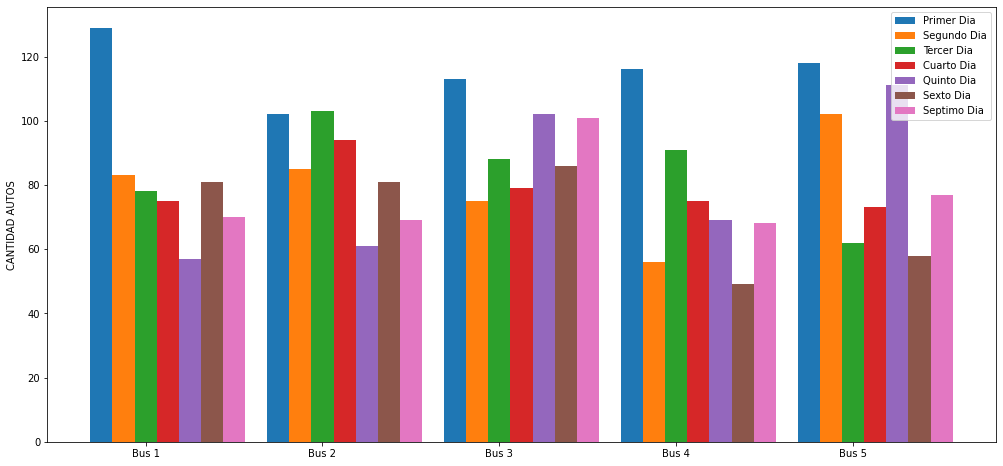

In [449]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(17,8), )
indice_barras = np.arange(5)
ancho_barras = 0.125

contDia = 0
listaValorDia0 = []
listaValorDia1 = []
listaValorDia2 = []
listaValorDia3 = []
listaValorDia4 = []
listaValorDia5 = []
listaValorDia6 = []
for key in boletosVendidosPorDia:
  if(boletosVendidosPorDia[key][1] == 0):
    listaValorDia0.append(boletosVendidosPorDia[key][2])
  if(boletosVendidosPorDia[key][1] == 1):
      listaValorDia1.append(boletosVendidosPorDia[key][2])
  if(boletosVendidosPorDia[key][1] == 2):
      listaValorDia2.append(boletosVendidosPorDia[key][2])
  if(boletosVendidosPorDia[key][1] == 3):
      listaValorDia3.append(boletosVendidosPorDia[key][2])
  if(boletosVendidosPorDia[key][1] == 4):
      listaValorDia4.append(boletosVendidosPorDia[key][2])
  if(boletosVendidosPorDia[key][1] == 5):
      listaValorDia5.append(boletosVendidosPorDia[key][2])
  if(boletosVendidosPorDia[key][1] == 6):
      listaValorDia6.append(boletosVendidosPorDia[key][2])


print("listaValorDia0: ",listaValorDia0)
plt.bar(indice_barras, listaValorDia0, width=ancho_barras, label='Primer Dia')
plt.bar(indice_barras+ 1*ancho_barras, listaValorDia1, width=ancho_barras, label='Segundo Dia')
plt.bar(indice_barras+ 2*ancho_barras, listaValorDia2, width=ancho_barras, label='Tercer Dia')
plt.bar(indice_barras+ 3*ancho_barras, listaValorDia3, width=ancho_barras, label='Cuarto Dia')
plt.bar(indice_barras+ 4*ancho_barras, listaValorDia4, width=ancho_barras, label='Quinto Dia')
plt.bar(indice_barras+ 5*ancho_barras, listaValorDia5, width=ancho_barras, label='Sexto Dia')
plt.bar(indice_barras+ 6*ancho_barras, listaValorDia6, width=ancho_barras, label='Septimo Dia')

plt.xticks(indice_barras + 2*ancho_barras, (Buses))
plt.legend(loc='best')
plt.ylabel('CANTIDAD AUTOS')

#### Personas que se quedaron sin comprar tickets
- Personas sin Tickets por Bus en cada dia 

listaValorDia0:  [0, 0, 1, 8, 12]


Text(0, 0.5, 'CANTIDAD Personas que perdieron no compraron ticket')

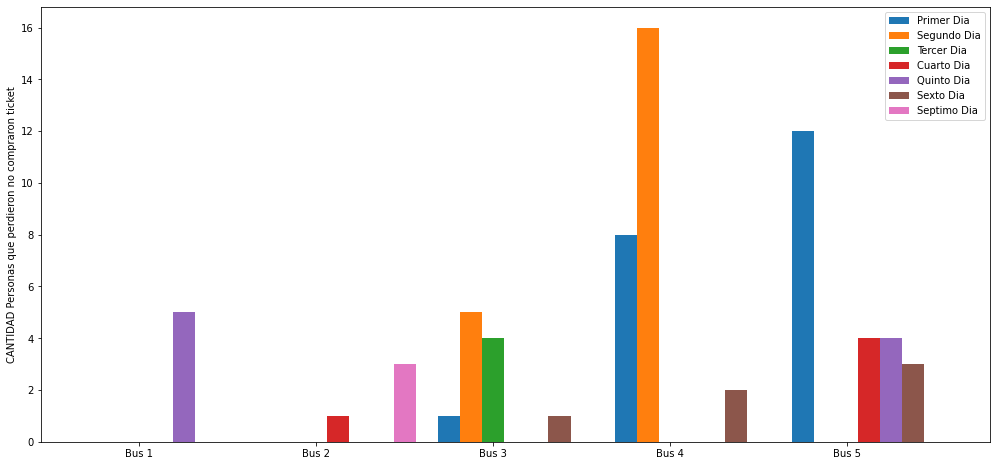

In [462]:
plt.figure(figsize=(17,8), )
indice_barras = np.arange(5)
ancho_barras = 0.125

contDia = 0
listaValorDia0 = []
listaValorDia1 = []
listaValorDia2 = []
listaValorDia3 = []
listaValorDia4 = []
listaValorDia5 = []
listaValorDia6 = []
for key in boletosVendidosPorDia:
  if(boletosVendidosPorDia[key][1] == 0):
    listaValorDia0.append(boletosVendidosPorDia[key][3])
  if(boletosVendidosPorDia[key][1] == 1):
      listaValorDia1.append(boletosVendidosPorDia[key][3])
  if(boletosVendidosPorDia[key][1] == 2):
      listaValorDia2.append(boletosVendidosPorDia[key][3])
  if(boletosVendidosPorDia[key][1] == 3):
      listaValorDia3.append(boletosVendidosPorDia[key][3])
  if(boletosVendidosPorDia[key][1] == 4):
      listaValorDia4.append(boletosVendidosPorDia[key][3])
  if(boletosVendidosPorDia[key][1] == 5):
      listaValorDia5.append(boletosVendidosPorDia[key][3])
  if(boletosVendidosPorDia[key][1] == 6):
      listaValorDia6.append(boletosVendidosPorDia[key][3])


print("listaValorDia0: ",listaValorDia0)
plt.bar(indice_barras, listaValorDia0, width=ancho_barras, label='Primer Dia')
plt.bar(indice_barras+ 1*ancho_barras, listaValorDia1, width=ancho_barras, label='Segundo Dia')
plt.bar(indice_barras+ 2*ancho_barras, listaValorDia2, width=ancho_barras, label='Tercer Dia')
plt.bar(indice_barras+ 3*ancho_barras, listaValorDia3, width=ancho_barras, label='Cuarto Dia')
plt.bar(indice_barras+ 4*ancho_barras, listaValorDia4, width=ancho_barras, label='Quinto Dia')
plt.bar(indice_barras+ 5*ancho_barras, listaValorDia5, width=ancho_barras, label='Sexto Dia')
plt.bar(indice_barras+ 6*ancho_barras, listaValorDia6, width=ancho_barras, label='Septimo Dia')

plt.xticks(indice_barras + 2*ancho_barras, (Buses))
plt.legend(loc='best')
plt.ylabel('CANTIDAD Personas que perdieron no compraron ticket')

#### Lugares de origen y destino más visitados.


- Lugares de Origen mas visitados 

In [464]:
listaOrigen = ["Quito","Guayaquil","Cuenca","Ambato","Manta","Machala"]

listaValorDia0:  [0, 0, 1, 8, 12]


Text(0, 0.5, 'numero de apariciones de origen entre semana')

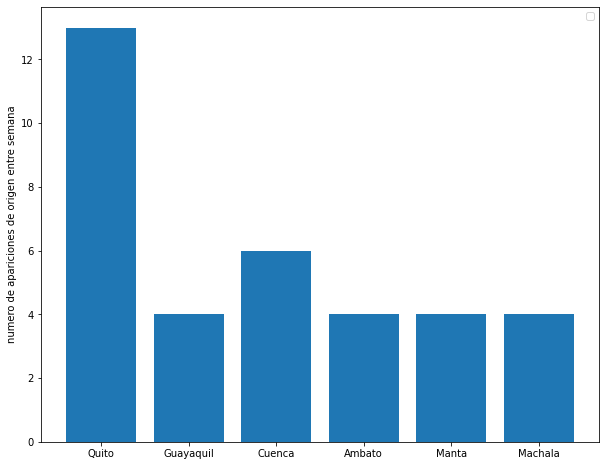

In [471]:
plt.figure(figsize=(10,8), )
indice_barras = np.arange(5)
ancho_barras = 0.125

contDia = 0
listaValorCiudad0 = 0
listaValorCiudad1 = 0
listaValorCiudad2 = 0
listaValorCiudad3 = 0
listaValorCiudad4 = 0
listaValorCiudad5 = 0
for key in boletosVendidosPorDia:
  if(boletosVendidosPorDia[key][4] == 'Quito'):
    listaValorCiudad0 += 1
  if(boletosVendidosPorDia[key][4] == 'Guayaquil'):
    listaValorCiudad1 += 1
  if(boletosVendidosPorDia[key][4] == 'Cuenca'):
    listaValorCiudad2 += 1
  if(boletosVendidosPorDia[key][4] == 'Ambato'):
    listaValorCiudad3 += 1
  if(boletosVendidosPorDia[key][4] == 'Manta'):
    listaValorCiudad4 += 1
  if(boletosVendidosPorDia[key][4] == 'Machala'):
    listaValorCiudad5 += 1

listaValores = [listaValorCiudad0,
                listaValorCiudad1,
                listaValorCiudad2,
                listaValorCiudad3,
                listaValorCiudad4,
                listaValorCiudad5
                ]

print("listaValorDia0: ",listaValorDia0)
plt.bar(listaOrigen, listaValores)
plt.legend(loc='best')
plt.ylabel('numero de apariciones de origen entre semana')

- Lugares de Destinos mas visitados 

In [ ]:
listaLugaresTuristicos = ["Quito","Guayaquil","Montañita","Baños de Agua Santa","Cuenca", "Puyo"]

Text(0, 0.5, 'numero de apariciones de destino entre semana')

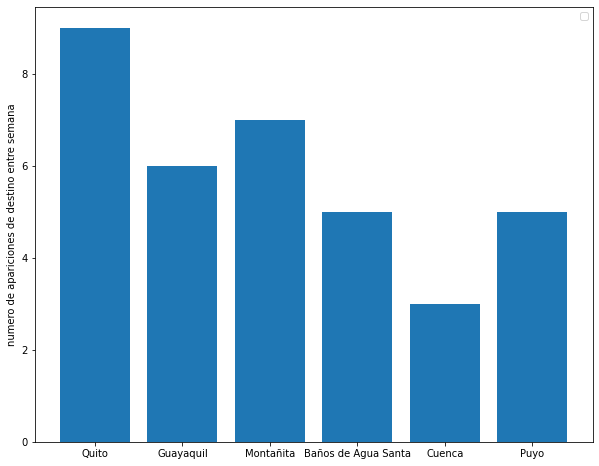

In [473]:
plt.figure(figsize=(10,8), )
indice_barras = np.arange(5)
ancho_barras = 0.125

contDia = 0
listaValorCiudad0 = 0
listaValorCiudad1 = 0
listaValorCiudad2 = 0
listaValorCiudad3 = 0
listaValorCiudad4 = 0
listaValorCiudad5 = 0
for key in boletosVendidosPorDia:
  if(boletosVendidosPorDia[key][5] == 'Quito'):
    listaValorCiudad0 += 1
  if(boletosVendidosPorDia[key][5] == 'Guayaquil'):
    listaValorCiudad1 += 1
  if(boletosVendidosPorDia[key][5] == 'Montañita'):
    listaValorCiudad2 += 1
  if(boletosVendidosPorDia[key][5] == 'Baños de Agua Santa'):
    listaValorCiudad3 += 1
  if(boletosVendidosPorDia[key][5] == 'Cuenca'):
    listaValorCiudad4 += 1
  if(boletosVendidosPorDia[key][5] == 'Puyo'):
    listaValorCiudad5 += 1

listaValores = [listaValorCiudad0,
                listaValorCiudad1,
                listaValorCiudad2,
                listaValorCiudad3,
                listaValorCiudad4,
                listaValorCiudad5
                ]

plt.bar(listaLugaresTuristicos, listaValores)
plt.legend(loc='best')
plt.ylabel('numero de apariciones de destino entre semana')

#### Numero de buses y el uso del mismo diarios

In [478]:
boletosVendidosPorDia

{'Bus 1 dia:0': ['Bus 1', 0, 89, 0, 6, 'Quito', 'Guayaquil'],
 'Bus 1 dia:1': ['Bus 1', 1, 83, 0, 3, 'Quito', 'Montañita'],
 'Bus 1 dia:2': ['Bus 1', 2, 78, 0, 5, 'Cuenca', 'Baños de Agua Santa'],
 'Bus 1 dia:3': ['Bus 1', 3, 75, 0, 2, 'Ambato', 'Cuenca'],
 'Bus 1 dia:4': ['Bus 1', 4, 57, 5, 4, 'Quito', 'Puyo'],
 'Bus 1 dia:5': ['Bus 1', 5, 81, 0, 4, 'Quito', 'Guayaquil'],
 'Bus 1 dia:6': ['Bus 1', 6, 70, 0, 6, 'Cuenca', 'Puyo'],
 'Bus 2 dia:0': ['Bus 2', 0, 62, 0, 2, 'Guayaquil', 'Quito'],
 'Bus 2 dia:1': ['Bus 2', 1, 85, 0, 5, 'Quito', 'Cuenca'],
 'Bus 2 dia:2': ['Bus 2', 2, 103, 0, 3, 'Ambato', 'Quito'],
 'Bus 2 dia:3': ['Bus 2', 3, 94, 1, 3, 'Quito', 'Montañita'],
 'Bus 2 dia:4': ['Bus 2', 4, 61, 0, 2, 'Manta', 'Quito'],
 'Bus 2 dia:5': ['Bus 2', 5, 81, 0, 2, 'Guayaquil', 'Puyo'],
 'Bus 2 dia:6': ['Bus 2', 6, 69, 3, 3, 'Machala', 'Quito'],
 'Bus 3 dia:0': ['Bus 3', 0, 73, 1, 2, 'Quito', 'Montañita'],
 'Bus 3 dia:1': ['Bus 3', 1, 75, 5, 1, 'Quito', 'Puyo'],
 'Bus 3 dia:2': ['Bus 3',

listaValorDia0:  [6, 2, 2, 1, 2]


Text(0, 0.5, 'CANTIDAD VIAJES')

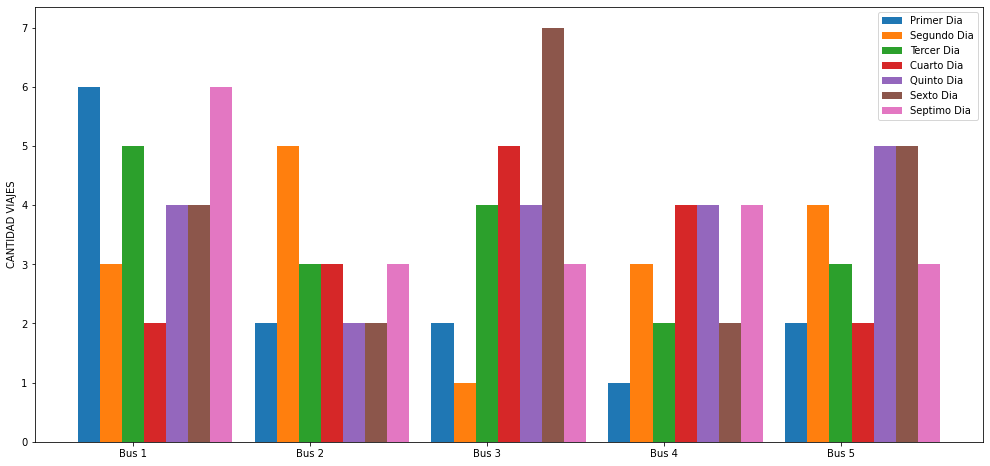

In [480]:
plt.figure(figsize=(17,8), )
indice_barras = np.arange(5)
ancho_barras = 0.125

contDia = 0
listaValorDia0 = []
listaValorDia1 = []
listaValorDia2 = []
listaValorDia3 = []
listaValorDia4 = []
listaValorDia5 = []
listaValorDia6 = []
for key in boletosVendidosPorDia:
  if(boletosVendidosPorDia[key][1] == 0):
    listaValorDia0.append(boletosVendidosPorDia[key][4])
  if(boletosVendidosPorDia[key][1] == 1):
      listaValorDia1.append(boletosVendidosPorDia[key][4])
  if(boletosVendidosPorDia[key][1] == 2):
      listaValorDia2.append(boletosVendidosPorDia[key][4])
  if(boletosVendidosPorDia[key][1] == 3):
      listaValorDia3.append(boletosVendidosPorDia[key][4])
  if(boletosVendidosPorDia[key][1] == 4):
      listaValorDia4.append(boletosVendidosPorDia[key][4])
  if(boletosVendidosPorDia[key][1] == 5):
      listaValorDia5.append(boletosVendidosPorDia[key][4])
  if(boletosVendidosPorDia[key][1] == 6):
      listaValorDia6.append(boletosVendidosPorDia[key][4])


print("listaValorDia0: ",listaValorDia0)
plt.bar(indice_barras, listaValorDia0, width=ancho_barras, label='Primer Dia')
plt.bar(indice_barras+ 1*ancho_barras, listaValorDia1, width=ancho_barras, label='Segundo Dia')
plt.bar(indice_barras+ 2*ancho_barras, listaValorDia2, width=ancho_barras, label='Tercer Dia')
plt.bar(indice_barras+ 3*ancho_barras, listaValorDia3, width=ancho_barras, label='Cuarto Dia')
plt.bar(indice_barras+ 4*ancho_barras, listaValorDia4, width=ancho_barras, label='Quinto Dia')
plt.bar(indice_barras+ 5*ancho_barras, listaValorDia5, width=ancho_barras, label='Sexto Dia')
plt.bar(indice_barras+ 6*ancho_barras, listaValorDia6, width=ancho_barras, label='Septimo Dia')

plt.xticks(indice_barras + 2*ancho_barras, (Buses))
plt.legend(loc='best')
plt.ylabel('CANTIDAD VIAJES')